
---

# 🧪 Lab 5 Summary – Baseline CNN for Image-to-Image Translation

## 🎯 Objective

The objective of this lab is to implement a baseline **Encoder–Decoder Convolutional Neural Network (CNN)** for paired image-to-image translation using the CIFAR-10 dataset and analyze its performance using reconstruction loss (L1 / MSE).

---

## 🛠️ What We Did

In this experiment, we performed image-to-image translation where:

* 🖤 **Input:** Grayscale image
* 🎨 **Target:** Original RGB image

The model learns to convert grayscale images into color images.

---

## ⚙️ Implementation Steps

### 1️⃣ Dataset Loading

* Used the CIFAR-10 dataset.
* Created paired data:

  * Converted original image to grayscale → Input
  * Used original RGB image → Target

---

### 2️⃣ Normalization

* Images were normalized to the range **[-1, 1]** 🔄
* Used:

  * `Normalize((0.5),(0.5))` for grayscale
  * `Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))` for RGB

Normalization helps in faster and stable training 🚀.

---

### 3️⃣ Model Architecture (Encoder–Decoder CNN) 🧠

#### 🔹 Encoder:

* Conv2D layers
* Reduces spatial dimension (32×32 → 8×8)
* Extracts important features

#### 🔹 Decoder:

* ConvTranspose2D layers
* Upsamples image (8×8 → 32×32)
* Final activation: **Tanh** (to match [-1,1])

This is a simple reconstruction-based model (❌ No GAN used).

---

### 4️⃣ Loss Function 📉

* Used **L1 Loss** (can also use MSE Loss)
* Measures pixel-wise difference between output and target image.

Lower loss means better reconstruction ✔️.

---

### 5️⃣ Training Process 🏋️

* Optimizer: Adam
* Trained for multiple epochs
* Loss decreased gradually → Model is learning 📊

---

### 6️⃣ Output Visualization 🖼️

We compared:

* Input (Grayscale)
* Target (Original RGB)
* Output (Predicted RGB)

The generated images were **blurry**, which is expected.

---

## ❓ Why Output is Blurry?

Because:

* Only reconstruction loss (L1/MSE) is used 📉
* No adversarial loss (GAN) to produce sharp images ❌
* Model predicts average color distribution
* CIFAR-10 images are small (32×32 resolution)

---

## ✅ Conclusion

In this lab, we successfully implemented a baseline **Encoder–Decoder CNN** for image-to-image translation. The model learned to reconstruct color images from grayscale inputs using reconstruction loss. Although the outputs were blurry, the experiment demonstrates how basic CNN architectures perform pixel-level image translation without adversarial training.


100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Epoch [1/5] Loss: 0.1517
Epoch [2/5] Loss: 0.1142
Epoch [3/5] Loss: 0.1087
Epoch [4/5] Loss: 0.1058
Epoch [5/5] Loss: 0.1038


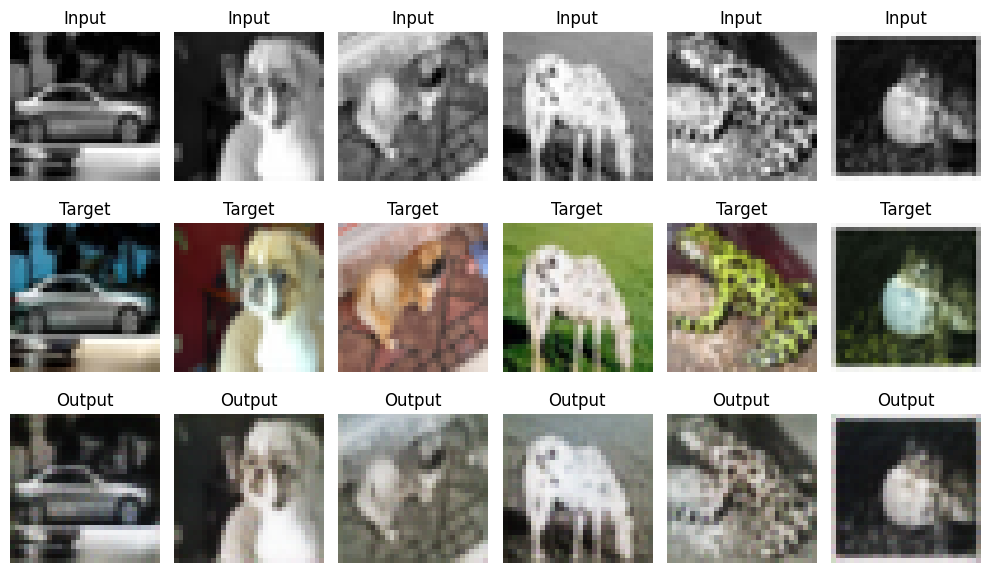

In [1]:
# ==============================
# LAB 5 – Baseline Encoder-Decoder CNN (No GAN)
# Dataset: CIFAR10
# ==============================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 1. Load Paired Images
# ------------------------------
# Input: Grayscale Image
# Target: Original RGB Image

transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # Normalize to [-1,1]
])

transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))  # Normalize to [-1,1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True
)

# Create paired dataset
class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        input_img = transform_gray(img)
        target_img = transform_rgb(img)
        return input_img, target_img

train_loader = torch.utils.data.DataLoader(
    PairedDataset(train_dataset),
    batch_size=128,
    shuffle=True
)

# ------------------------------
# 2. Encoder–Decoder CNN
# ------------------------------
class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16x16 -> 8x8
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),   # 16x16 -> 32x32
            nn.Tanh()  # Output in [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = EncoderDecoder().to(device)

# ------------------------------
# 3. Loss and Optimizer
# ------------------------------
criterion = nn.L1Loss()  # You can change to nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# ------------------------------
# 4. Training
# ------------------------------
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    for input_img, target_img in train_loader:
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        output = model(input_img)
        loss = criterion(output, target_img)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")

# ------------------------------
# 5. Visualization
# ------------------------------
model.eval()
with torch.no_grad():
    input_img, target_img = next(iter(train_loader))
    input_img = input_img.to(device)
    output = model(input_img)

# Denormalize
def denorm(x):
    return (x + 1) / 2

input_img = denorm(input_img.cpu())
target_img = denorm(target_img)
output = denorm(output.cpu())

# Show results
fig, axes = plt.subplots(3,6, figsize=(10,6))

for i in range(6):
    axes[0,i].imshow(input_img[i].permute(1,2,0).squeeze(), cmap='gray')
    axes[0,i].set_title("Input")
    axes[0,i].axis('off')

    axes[1,i].imshow(target_img[i].permute(1,2,0))
    axes[1,i].set_title("Target")
    axes[1,i].axis('off')

    axes[2,i].imshow(output[i].permute(1,2,0))
    axes[2,i].set_title("Output")
    axes[2,i].axis('off')

plt.tight_layout()
plt.show()
